# ACEH-INDONESIA Machine Translation KEL 7




## Install Library

In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install accelerate
!pip install evaluate
!pip install scikit-learn
!pip install bert-score
!pip install sacrebleu
!pip install sentencepiece
import torch
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import load_dataset
from sacrebleu.metrics import BLEU, CHRF, TER
from bert_score import score as bert_score
from nltk.translate.meteor_score import meteor_score
import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sentencepiece
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from wordcloud import WordCloud
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers import AdamW, get_linear_schedule_with_warmup
from datasets import Dataset as DatasetHF
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm


  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
Using cached evaluate-0.4.3-py3-none-any.whl (84 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 8.6 MB/s eta 0:00:00


## Input Datasets



In [2]:

aceh_indo= load_dataset("indonlp/NusaX-MT", name='ace-ind', trust_remote_code=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.64k [00:00<?, ?B/s]

NusaX-MT.py:   0%|          | 0.00/5.69k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

## Exploratory Datasets Analysis



In [3]:
display(aceh_indo)

DatasetDict({
    train: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 500
    })
    validation: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 100
    })
    test: Dataset({
        features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
        num_rows: 400
    })
})

### Konversi Dataset ke Pandas Dataframe



In [4]:
df_train = aceh_indo['train'].to_pandas()
df_test = aceh_indo['test'].to_pandas()
df_valid = aceh_indo['validation'].to_pandas()

In [5]:
display(df_train)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,ace,ind
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Kue-kue yang disajikan bikin saya bernostalgia...,ace,ind
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu pernah bekerja di grab indonesia,ace,ind
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling suka banget makan siang di sini ayam sa...,ace,ind
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI sangat baik,ace,ind
...,...,...,...,...,...
495,495,"Si A 'oh dipeugah haba lagee tong hana asoe, h...",Si A omongnya tong kosong nyaring bunyinya bic...,ace,ind
496,496,Sambaijih hana bak teumpat laen. Rasa teurasij...,Sambalnya tidak akan ada di tempat lain. Rasa ...,ace,ind
497,497,"Bak lon rasa, steakjih cukop mangat, tapi leub...","Menurut saya steaknya cukup enak, hanya lebih ...",ace,ind
498,498,"Nyan tajaga peunajoh gus, cit lawet nyoe teung...",Dijaga ya makannya gus emang lagi musimnya sek...,ace,ind


### Menyatukan Dataset

In [6]:
df = pd.concat(
    [
       df_train,
       df_test,
       df_valid
    ],
    axis=0,
    ignore_index=True
    )

display(df)

,id,text_1,text_2,text_1_lang,text_2_lang
0,0,Neumeuseunang ngon neubayeue bacut-bacut angsu...,Nikmati cicilan 0% hingga 12 bulan untuk pemes...,ace,ind
1,1,Kueh nyang dihidang peuingat lon masa dilee. B...,Kue-kue yang disajikan bikin saya bernostalgia...,ace,ind
2,2,Ibu tom geukereuja bak Grab Indonesia,Ibu pernah bekerja di grab indonesia,ace,ind
3,3,"Paleng galak ta pajoh bu leuho inoe, manok ngo...",Paling suka banget makan siang di sini ayam sa...,ace,ind
4,4,Peulayanan bus DAMRI cukop get,Pelayanan bus DAMRI sangat baik,ace,ind
...,...,...,...,...,...
995,95,Tulong neubi info atm toh mantong yang na di S...,Mohon informasikan atm mana saja di semarang y...,ace,ind
996,96,Rakan geurekomendasi teumpat nyoe saweueb rasa...,Teman merekomendasikan tempat ini karena rasa ...,ace,ind
997,97,"Phon keunoe lon peu sepele, pah watee loen deu...","Pertama ke sini saya under estimate, pas waktu...",ace,ind
998,98,Teumpatjih mangat keu nyang ka meukeuluarga at...,Tempatnya menyenangkan baik untuk yang sudah b...,ace,ind


### Distribusi Kata



WordClouds


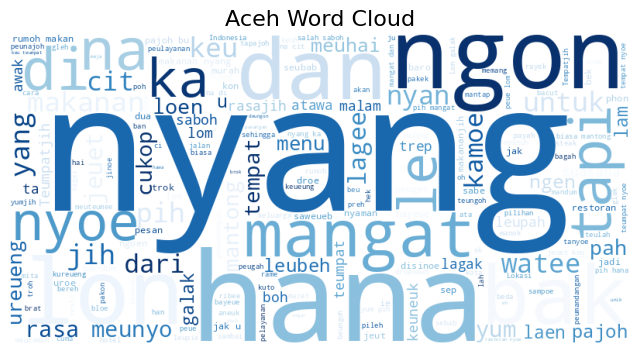

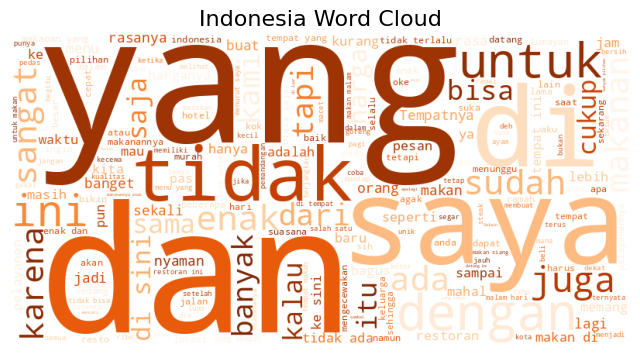

In [7]:
def word_cloud(text, title, colormap):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormap
    ).generate(" ".join(text))

    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title, fontsize=16)
    plt.show()

# Word cloud untuk Aceh dengan colormap 'Blues'
word_cloud(df['text_1'], 'Aceh Word Cloud', colormap='Blues')

# Word cloud untuk Indonesia dengan colormap 'Oranges'
word_cloud(df['text_2'], 'Indonesia Word Cloud', colormap='Oranges')

<ipython-input-8-c4104fb1d761>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-8-c4104fb1d761>:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


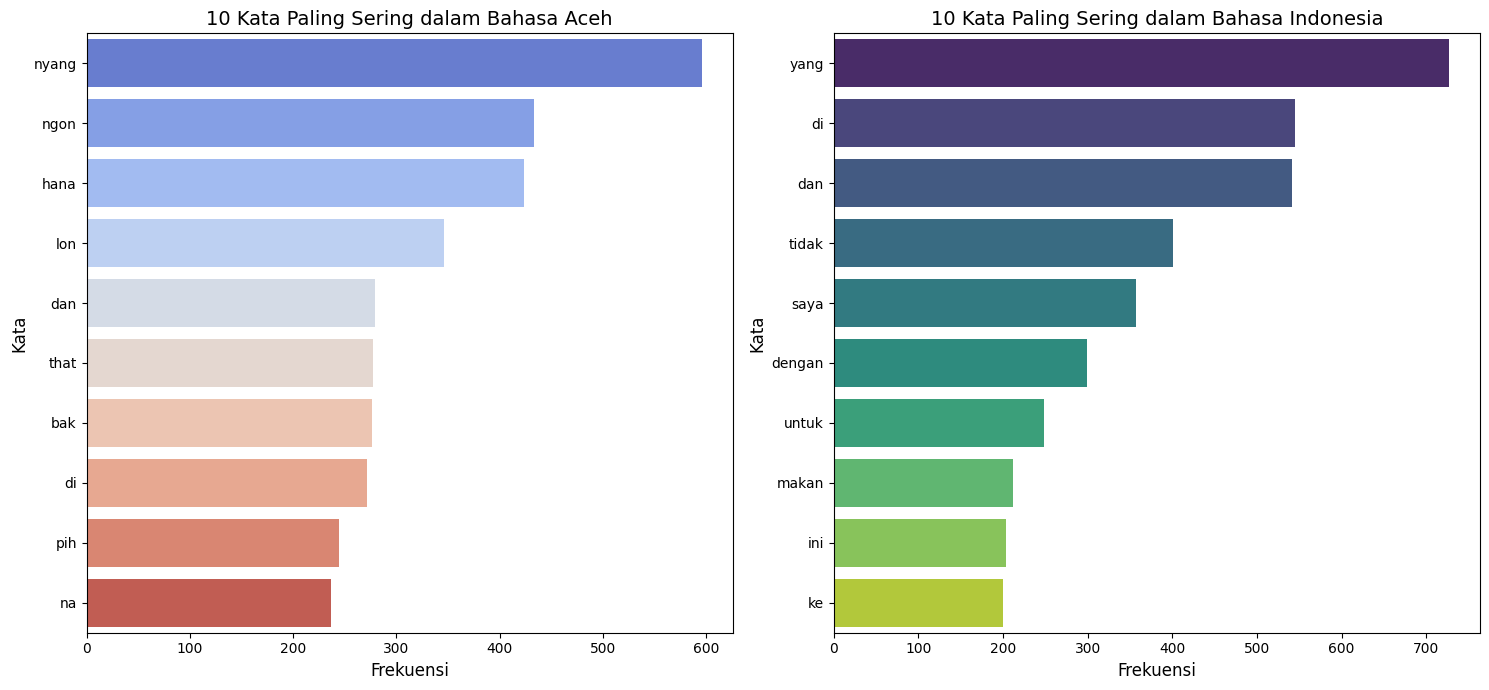

In [8]:

import matplotlib.pyplot as plt
from collections import Counter

# Fungsi untuk mendapatkan kata paling umum
def get_most_common_words(series, n_most_common=10):
    counter = Counter()
    for sentence in series:
        counter.update(sentence.lower().split())
    return counter.most_common(n_most_common)

# Menyiapkan data untuk Bahasa Aceh dan Bahasa Indonesia
most_common_aceh = get_most_common_words(df['text_1'])
most_common_indo = get_most_common_words(df['text_2'])

# Mengubah hasil menjadi DataFrame untuk plot
df_aceh = pd.DataFrame(most_common_aceh, columns=['Word', 'Frequency'])
df_indo = pd.DataFrame(most_common_indo, columns=['Word', 'Frequency'])

# Membuat plot
plt.figure(figsize=(15, 7))

# Subplot untuk Bahasa Aceh
plt.subplot(1, 2, 1)
sns.barplot(
    x='Frequency',
    y='Word',
    data=df_aceh,
    palette='coolwarm'  # Skema warna untuk Aceh
)
plt.title('10 Kata Paling Sering dalam Bahasa Aceh', fontsize=14)
plt.xlabel('Frekuensi', fontsize=12)
plt.ylabel('Kata', fontsize=12)

# Subplot untuk Bahasa Indonesia
plt.subplot(1, 2, 2)
sns.barplot(
    x='Frequency',
    y='Word',
    data=df_indo,
    palette='viridis'  # Skema warna untuk Indonesia
)
plt.title('10 Kata Paling Sering dalam Bahasa Indonesia', fontsize=14)
plt.xlabel('Frekuensi', fontsize=12)
plt.ylabel('Kata', fontsize=12)

# Mengatur layout dan menampilkan plot
plt.tight_layout()
plt.show()

### N-Grams


BIGRAM

In [9]:
def ngrams(text, n=2):
    words = text.split()
    ngrams = zip(*[words[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]

bigrams_aceh = ngrams(" ".join(df['text_1']), n=2)
display(Counter(bigrams_aceh).most_common(10))

[('pajoh bu', 37),
 ('hana that', 37),
 ('jak u', 34),
 ('makanan nyang', 33),
 ('jeuet keu', 29),
 ('nyang ka', 25),
 ('pih hana', 25),
 ('na di', 23),
 ('rumoh makan', 23),
 ('nyang hana', 22)]

In [10]:
bigrams_indo = ngrams(" ".join(df['text_2']), n=2)
display(Counter(bigrams_indo).most_common(10))

[('makan di', 44),
 ('di sini', 39),
 ('makanan yang', 33),
 ('tidak ada', 31),
 ('ke sini', 30),
 ('tidak terlalu', 30),
 ('enak dan', 29),
 ('tempat ini', 28),
 ('yang sangat', 27),
 ('di tempat', 25)]

TRIGRAM

In [11]:
trigrams_aceh = ngrams(" ".join(df['text_1']), n=3)
display(Counter(trigrams_aceh).most_common(10))

[('pajoh bu leuho', 11),
 ('Rumoh makan nyoe', 7),
 ('nyang na di', 7),
 ('na di jalan', 7),
 ('rumoh makan nyoe', 6),
 ('peue lom meunyo', 5),
 ('pajoh bu bak', 5),
 ('nyang ka leupah,', 5),
 ('pih hana that', 5),
 ('mangat dan yum', 4)]

In [12]:
# Contoh untuk trigram dalam Bahasa Indonesia
trigrams_indo = ngrams(" ".join(df['text_2']), n=3)
display(Counter(trigrams_indo).most_common(10))

[('makan di sini.', 8),
 ('makan siang di', 7),
 ('untuk makan malam', 7),
 ('tidak ada yang', 7),
 ('Makanan di sini', 7),
 ('makanan dan minuman', 6),
 ('ke tempat ini', 5),
 ('dengan harga yang', 5),
 ('yang berada di', 5),
 ('di malam hari', 5)]

## Preprocessing

In [13]:
AcehIndo = DatasetHF.from_pandas(df)

display(AcehIndo)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
    num_rows: 1000
})

In [14]:
rasio = [0.8, 0.1, 0.1]  # 80% training, 10% validation, 10% test
nama_split = ['train', 'validation', 'test']

splits =AcehIndo.train_test_split(test_size=0.2)
train_dataset, valid_test_dataset = splits['train'], splits['test']

splits = valid_test_dataset.train_test_split(test_size=0.5)
valid_dataset, test_dataset = splits['train'], splits['test']

display(train_dataset)
display(test_dataset)
display(valid_dataset)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
    num_rows: 800
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
    num_rows: 100
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang'],
    num_rows: 100
})

In [15]:
checkpoint = "t5-base"
tokenizer = T5Tokenizer.from_pretrained(checkpoint)

source_lang = 'ace'
target_lang = 'ind'
prefix = "Translate Acehnese to Indonesian: "

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [16]:
def preprocess(examples):
    inputs = [prefix + src for src in examples["text_1"]]
    targets = examples["text_2"]
    model_inputs = tokenizer(inputs, max_length=256, truncation=True, padding="max_length", return_tensors="pt")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=256, truncation=True, padding="max_length", return_tensors="pt")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train = train_dataset.map(preprocess, batched=True)
tokenized_test = test_dataset.map(preprocess, batched=True)
tokenized_valid = valid_dataset.map(preprocess, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4114: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [17]:
display(tokenized_train)
display(tokenized_test)
display(tokenized_valid)

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 800
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

Dataset({
    features: ['id', 'text_1', 'text_2', 'text_1_lang', 'text_2_lang', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 100
})

In [18]:
tokenized_train['input_ids'][:1]

[[30355,
  15,
  16475,
  12836,
  7,
  15,
  12,
  9995,
  29,
  10,
  7870,
  127,
  152,
  3,
  29,
  9,
  158,
  348,
  2565,
  3,
  23,
  15,
  3,
  449,
  15,
  76,
  6959,
  6,
  10301,
  144,
  2576,
  1927,
  107,
  8524,
  3,
  4855,
  15,
  2662,
  6310,
  5,
  2215,
  6310,
  3,
  354,
  23,
  107,
  90,
  649,
  23,
  1337,
  63,
  76,
  115,
  10968,
  107,
  3,
  76,
  3,
  342,
  76,
  107,
  6,
  143,
  29,
  3,
  76,
  3,
  342,
  76,
  107,
  143,
  29,
  20,
  76,
  107,
  158,
  348,
  3768,
  2565,
  3,
  23,
  15,
  3,
  449,
  15,
  76,
  6959,
  5,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [19]:
tokenized_train['attention_mask'][:1]

[[1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


In [20]:
from transformers import DataCollatorForSeq2Seq

collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=checkpoint)

In [21]:
import evaluate

# Load metrics
sacrebleu_metric = evaluate.load("sacrebleu")
meteor_metric = evaluate.load("meteor")
bertscore_metric = evaluate.load("bertscore")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [22]:
def postprocess(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def hitung_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]

    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess(decoded_preds, decoded_labels)

    result = {}

    # sacreBLEU
    bleu_result = sacrebleu_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result["bleu"] = bleu_result["score"]

    # METEOR
    meteor_result = meteor_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result["meteor"] = meteor_result["meteor"]

    # BERTScore
    bertscore_result = bertscore_metric.compute(predictions=decoded_preds, references=decoded_labels, lang="en")
    result["bertscore_precision"] = np.mean(bertscore_result["precision"])
    result["bertscore_recall"] = np.mean(bertscore_result["recall"])
    result["bertscore_f1"] = np.mean(bertscore_result["f1"])

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}

    return result

In [23]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

training args

In [24]:
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, EarlyStoppingCallback # Import EarlyStoppingCallback

model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint)


training_args = Seq2SeqTrainingArguments(
    output_dir="KEL7_checkpoints",
    evaluation_strategy="steps",  # Evaluasi per beberapa langkah
    eval_steps=500,  # Evaluasi setiap 500 langkah
    save_steps=500,  # Simpan model setiap 500 langkah
    learning_rate=3e-5,  # Meningkatkan learning rate
    per_device_train_batch_size=16,  # Meningkatkan batch size jika GPU mendukung
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=5,
    num_train_epochs=110,  # Menurunkan jumlah epoch
    warmup_steps=500,  # Menggunakan warmup di awal pelatihan
    predict_with_generate=True,
    fp16=True,
    lr_scheduler_type='linear',  # Penurunan learning rate secara linear,
    load_best_model_at_end=True, # add this line to fix the error
    metric_for_best_model="eval_loss" # it is recommended to set this for EarlyStoppingCallback
)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train, # Make sure these variables exist in your environment
    eval_dataset=tokenized_valid, # Make sure these variables exist in your environment
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=hitung_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-f131e48742d2>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss,Validation Loss,Bleu,Meteor,Bertscore Precision,Bertscore Recall,Bertscore F1,Gen Len
500,2.552800,0.644516,0.253900,0.093900,0.865300,0.813900,0.838500,19.000000
1000,0.604100,0.610793,0.477500,0.118000,0.878200,0.823600,0.849700,18.930000
1500,0.722300,0.692966,0.246000,0.086700,0.861400,0.819900,0.839800,18.890000
2000,0.709500,0.674418,0.252500,0.085300,0.861800,0.818400,0.839200,18.900000
2500,0.703400,0.674476,0.252500,0.085300,0.861800,0.818400,0.839200,18.900000
3000,0.703700,0.674546,0.254000,0.085400,0.861400,0.818300,0.839000,18.900000
3500,0.703900,0.674507,0.252200,0.085100,0.861500,0.818400,0.839100,18.900000
4000,0.704500,0.674531,0.251300,0.085300,0.862100,0.818500,0.839400,18.900000
4500,0.702900,0.674517,0.252500,0.085300,0.861800,0.818500,0.839300,18.900000
5000,0.701100,0.674543,0.253700,0.085300,0.861800,0.818500,0.839300,18.900000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) 

TrainOutput(global_step=5500, training_loss=0.8646821400035511, metrics={'train_runtime': 5016.5385, 'train_samples_per_second': 17.542, 'train_steps_per_second': 1.096, 'total_flos': 2.679414718464e+16, 'train_loss': 0.8646821400035511, 'epoch': 110.0})

In [25]:
import os
from transformers import pipeline, AutoModelForSeq2SeqLM, T5Tokenizer

# Path penyimpanan model dan tokenizer
model_path = "/content/KEL_7_model"
os.makedirs(model_path, exist_ok=True)

# Menyimpan model dan tokenizer
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

print(f"Model and tokenizer saved at {model_path}")

# Memuat model dan tokenizer untuk inference
loaded_model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
loaded_tokenizer = T5Tokenizer.from_pretrained(model_path)

# Pipeline untuk inferensi
translator = pipeline("translation", model=loaded_model, tokenizer=loaded_tokenizer)

# Contoh prediksi
source = "Translate Acehnese to Indonesian: Lamun hadé, urang rék ngahaturkeun nuhun kana gawéna."
prediction = translator(source)
print(f"Prediction: {prediction[0]['translation_text']}")


Model and tokenizer saved at /content/KEL_7_model


/usr/local/lib/python3.10/dist-packages/transformers/pipelines/__init__.py:1140: UserWarning: "translation" task was used, instead of "translation_XX_to_YY", defaulting to "translation_en_to_de"
  warnings.warn(
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Prediction: Indonesisch übersetzt: Lamun hadé, urang rék ngahaturkeun nuhun kana gawéna.


In [37]:
# Save model and tokenizer
import pickle
import os
from google.colab import files

# Path untuk menyimpan model dan tokenizer
model_path = "/content/KEL_7_model/model_translation.pkl"  # Path untuk menyimpan model
tokenizer_path = "/content/KEL_7_model/tokenizer"         # Path untuk menyimpan tokenizer

# Pastikan direktori penyimpanan ada
os.makedirs("/content/KEL_7_model", exist_ok=True)

# Simpan model ke file pickle
with open(model_path, "wb") as model_file:
    pickle.dump(model, model_file)

# Simpan tokenizer menggunakan metode Hugging Face
tokenizer.save_pretrained(tokenizer_path)

print(f"Model saved as pickle at {model_path}")
print(f"Tokenizer saved at {tokenizer_path}")

# Download model file secara otomatis
print("Downloading model file...")
files.download(model_path)

# Download tokenizer folder secara otomatis
# Membuat file ZIP untuk tokenizer agar bisa didownload
import shutil
tokenizer_zip_path = "/content/KEL_7_model/tokenizer.zip"
shutil.make_archive("/content/KEL_7_model/tokenizer", 'zip', tokenizer_path)

print("Downloading tokenizer...")
files.download(tokenizer_zip_path)


Model saved as pickle at /content/KEL_7_model/model_translation.pkl
Tokenizer saved at /content/KEL_7_model/tokenizer


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Evaluasi



In [30]:
from transformers import pipeline
# Assuming you have saved the model as 'KEL_7_model' in the specified directory
model_name = "/content/KEL_7_model"
source = "Translate Acehnese to Indonesian:  Lamun hadé, urang rék ngahaturkeun nuhun kana gawéna"
# label = "If you have further questions you'd like to ask, or have issues regarding Traveloka's products, be sure to contact us again."

translator = pipeline("translation", model=model_name)
translator(source)




You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'translation_text': 'Indonesisch übersetzt: Lamun hadé, urang rék ngahaturkeun nuhun kana gawéna'}]

In [31]:

def predict_evaluate(data):
    try:
        sources = data['text_1']
        targets = data['text_2']

        predictions = [translator(prefix + source)[0]['translation_text'] for source in sources]

        predicts, accuracies, bleus, meteors, bertscore_precisions, bertscore_recalls, bertscore_f1s = [], [], [], [], [], [], []

        for prediction, target in zip(predictions, targets):
            predicts.append(prediction)

            bleu_result = sacrebleu_metric.compute(predictions=[prediction], references=[target])
            bleus.append(bleu_result["score"])

            meteor_result = meteor_metric.compute(predictions=[prediction], references=[target])
            meteors.append(meteor_result["meteor"])

            bertscore_result = bertscore_metric.compute(predictions=[prediction], references=[target], lang="en")
            bertscore_precisions.append(bertscore_result["precision"])
            bertscore_recalls.append(bertscore_result["recall"])
            bertscore_f1s.append(bertscore_result["f1"])

        return {
            "input": data['text_1'],
            "predict": predicts,
            "target": targets,
            "bleu": bleus,
            "meteor": meteors,
            "bertscore_precision": bertscore_precisions,
            "bertscore_recall": bertscore_recalls,
            "bertscore_f1": bertscore_f1s
        }

    except Exception as e:
        print(f"Error during prediction or evaluation: {e}")
        return None
data_test_predict_eval = test_dataset.map(predict_evaluate, batched=True)



Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Your input_length: 289 is bigger than 0.9 * max_length: 300. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


In [32]:
predict_eval_df = data_test_predict_eval.to_pandas()

display(predict_eval_df.drop(['text_1', 'text_2', 'text_1_lang', 'text_2_lang'], axis=1))

,id,input,predict,target,bleu,meteor,bertscore_precision,bertscore_recall,bertscore_f1
0,208,"Nyum makananjih biasa mantong, yum pih meuha...",Indah makanannya biasa mahal. Tempat saya bias...,Rasa makanannya biasa saja dan harganya mahal....,17.145997,0.452792,[0.9332854151725769],[0.8937076330184937],[0.9130678176879883]
1,9,Meunyo tajak u The Peak memang terasa leupah j...,Indonesisch: Memang tajak u The Peak memang te...,Untuk menuju ke the peak memang terasa sangat ...,6.864175,0.441584,[0.8776286840438843],[0.8789535760879517],[0.878290593624115]
2,40,Bajee gadoh hana tanggong jaweueb.. hotel bint...,Indonesisch übersetzt: Bajee gadoh hana tanggo...,Baju hilang ga tanggung jawab.. hotel bintang ...,14.879641,0.311888,[0.8443739414215088],[0.8768345713615417],[0.8602980971336365]
3,205,Jinoe wisatawan nyang galak diving that kecewa...,Indah wisatawan yang galak diving that kecewa ...,Saat ini para wisatawan pecinta diving sangat ...,15.540137,0.394575,[0.899457573890686],[0.8774844408035278],[0.8883351683616638]
4,402,Gojek akan mulai buka layanan bak meupadup boh...,Indonesisch: Gojek akan mulai buka layanan bak...,Gojek akan mulai membuka layanan mereka di beb...,17.678749,0.609756,[0.8833933472633362],[0.9051649570465088],[0.8941466808319092]
...,...,...,...,...,...,...,...,...,...
95,239,Atlet muda nanggroe ikut serpong run 2018 untu...,Indonesisch übersetzt: Atlet muda nanggroe iku...,Atlet muda tanah air ikuti serpong run 2018 un...,47.855439,0.733657,[0.8952760696411133],[0.943740963935852],[0.9188699126243591]
96,232,120 peserta nyang luloh akan dibagi lam peut b...,Indonesisch übersetzen: 120 peserta yang lulu ...,120 peserta yang lulus ini akan dibagi menjadi...,10.307387,0.436047,[0.8451001644134521],[0.8816589117050171],[0.862992525100708]
97,187,Musem ujeuen lagee nyoe tiep ujeuen pasti hana...,Indonesisch übersetzt: Musem ujeuen lagi ini t...,Musim hujan begini setiap hujan pasti tidak te...,2.627962,0.043860,[0.8148638010025024],[0.8389971256256104],[0.8267543911933899]
98,150,Peujioh narkoba nakeuh salah saboh cara nyang ...,Indonesisch übersetzt: Pejioh narkoba kepada s...,Jauhi narkoba adalah salah satu cara yang bisa...,22.894157,0.515832,[0.8679015636444092],[0.8907686471939087],[0.8791863918304443]


In [33]:
display(predict_eval_df[:1]['predict'])
display(predict_eval_df[:1]['target'])

,predict
0,Indah makanannya biasa mahal. Tempat saya bias...


,target
0,Rasa makanannya biasa saja dan harganya mahal....


In [34]:
predict_eval_df['bleu'].mean()

10.039561730891858

In [35]:
predict_eval_df['meteor'].mean()

0.3085288969790315